In [1]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def get_data():

    transform = transforms.Compose([
        transforms.ToTensor()
    ])

    train = torchvision.datasets.MNIST(
        root="data",
        train=True,
        transform=transform,
        download=True
    )

    test = torchvision.datasets.MNIST(
        root="data",
        train=False,
        transform=transform,
        download=True
    )

    train_loader = DataLoader(train, batch_size=32, shuffle=True)
    test_loader = DataLoader(test, batch_size=32)

    return train_loader, test_loader


In [2]:
import torch
train_loader, test_loader = get_data()
image, label = next(iter(train_loader))
torch.unique(label), image.shape  

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), torch.Size([32, 1, 28, 28]))

In [3]:
image, label = next(iter(train_loader))

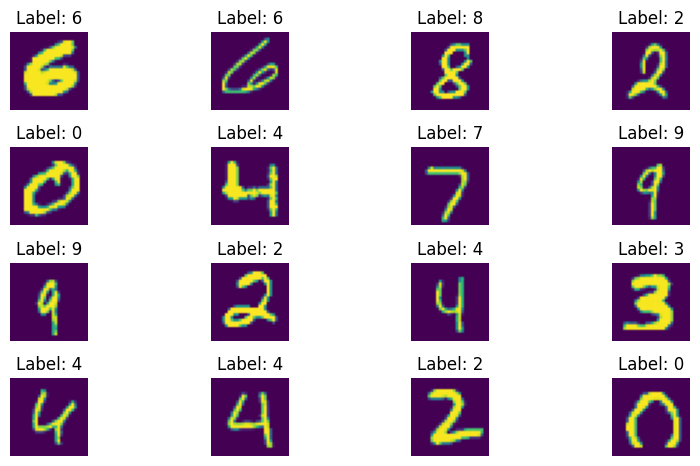

In [4]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(42)

fig = plt.figure(figsize=(10, 5))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):

    rand_idx = torch.randint(0, len(train_loader.dataset), size=(1,)).item()
    img, label = train_loader.dataset[rand_idx]

    fig.add_subplot(rows, cols, i)

    plt.imshow(img.permute(1, 2, 0))  # RGB images
    plt.title(f"Label: {label}")
    plt.tight_layout()
    plt.axis(False)

plt.show()


In [5]:
from torch import nn
# create a convolutional nerual network
class HandwrittenModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int):
        super().__init__()
        self.conv_block_1  = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_unit,
                kernel_size=3,
                stride=1,
                padding=1
            ), # values we can set ourselves is our nn's are called hyperparmeters
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_unit,
                out_channels=hidden_unit,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_unit,
                out_channels=hidden_unit,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_unit,
                out_channels=hidden_unit,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_unit*7*7, # there is trick to calculating this...
                      out_features=output_shape)
        )
    def forward(self, x):
        x = self.conv_block_1(x)
      
        x = self.conv_block_2(x)
 
       
        x = self.classifier(x)
        return x

In [6]:
model = HandwrittenModelV2(1, 32, 10)

In [7]:
from tqdm.auto import tqdm
y_pred = []
 

model.eval()
with torch.inference_mode():
    for x, y in tqdm(test_loader, desc='making prediction..........'):
        y_logist = model(x)

        y_preds = torch.softmax(y_logist.squeeze(), dim=0).argmax(dim=1)

        y_pred.append(y_preds)
        
y_pred_tensor = torch.cat(y_pred)
y_pred_tensor 

making prediction..........:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 7, 0,  ..., 3, 7, 3])

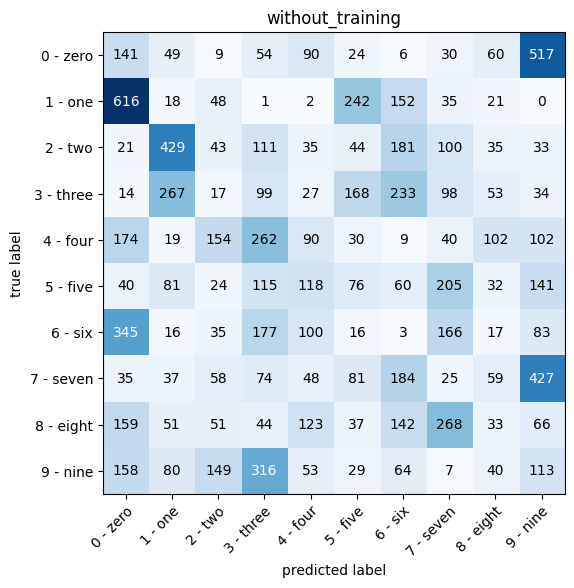

6.41


In [8]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Number of classes
num_classes = len(test_loader.dataset.classes)

# Create confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)

# Generate matrix
confmat_tensor = confmat(
    preds=y_pred_tensor,
    target=test_loader.dataset.targets
)

# Plot
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=test_loader.dataset.classes,
    figsize=(10,6)
)
plt.title('without_training')
plt.show()
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
accuracy = accuracy_fn(test_loader.dataset.targets, y_pred_tensor)
print(accuracy)



In [9]:

loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)


In [10]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fun: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               ):
    train_loss, train_acc = 0, 0

    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X, y

        y_pred = model(X)

        loss = loss_fun(y_pred, y)
        train_loss += loss.item()
        train_acc  += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f'train loss : {train_acc:.5f}| train accuracy: {train_acc:.2f}%')    



In [11]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fun: torch.nn.Module,
               accuracy_fn,
                ):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():

        for batch, (X, y) in enumerate(data_loader):
            X, y = X , y 

            y_pred = model(X)

            loss = loss_fun(y_pred, y)
            test_loss += loss.item()
            test_acc  += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

               

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f'test loss : {test_acc:.5f}| test accuracy: {test_acc:.2f}%')    



In [12]:
torch.manual_seed(42)
epochs = 5

for epoch in tqdm(range(epochs)):
    print(f'Epoch : {epoch}\n\n-------------')
    train_step(
        model=model,
        data_loader=train_loader,
        loss_fun=loss_fun,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
   
    )
    test_step(
        model=model,
        data_loader=test_loader,
        loss_fun=loss_fun,
        accuracy_fn=accuracy_fn,
 
    )
 

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0

-------------
train loss : 91.66833| train accuracy: 91.67%
test loss : 98.34265| test accuracy: 98.34%
Epoch : 1

-------------
train loss : 98.28167| train accuracy: 98.28%
test loss : 98.74201| test accuracy: 98.74%
Epoch : 2

-------------
train loss : 98.78833| train accuracy: 98.79%
test loss : 98.68211| test accuracy: 98.68%
Epoch : 3

-------------
train loss : 98.99167| train accuracy: 98.99%
test loss : 98.91174| test accuracy: 98.91%
Epoch : 4

-------------
train loss : 99.20000| train accuracy: 99.20%
test loss : 98.88179| test accuracy: 98.88%


In [13]:
from tqdm.auto import tqdm
y_pred = []

model.eval()
with torch.inference_mode():
    for x, y in tqdm(test_loader, desc='making prediction..........'):
        y_logist = model(x)

        y_preds = torch.softmax(y_logist.squeeze(), dim=0).argmax(dim=1)

        y_pred.append(y_preds)

y_pred_tensor = torch.cat(y_pred)
y_pred_tensor

making prediction..........:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([7, 2, 1,  ..., 4, 5, 6])

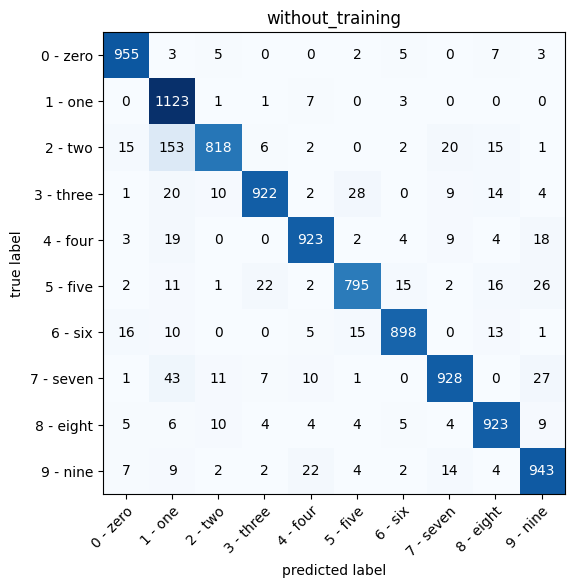

92.28


In [14]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Number of classes
num_classes = len(test_loader.dataset.classes)

# Create confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)

# Generate matrix
confmat_tensor = confmat(
    preds=y_pred_tensor,
    target=test_loader.dataset.targets
)

# Plot
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=test_loader.dataset.classes,
    figsize=(10,6)
)
plt.title('without_training')
plt.show()
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
accuracy = accuracy_fn(test_loader.dataset.targets, y_pred_tensor)
print(accuracy)



<function matplotlib.pyplot.show(close=None, block=None)>

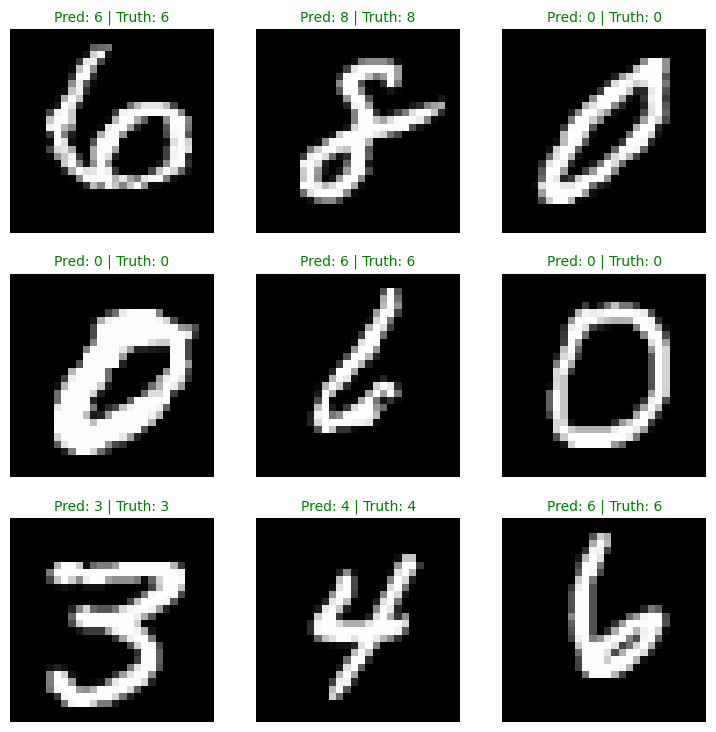

In [15]:
import torch
import matplotlib.pyplot as plt

# Define class names (MNIST)
class_name = [str(i) for i in range(10)]

plt.figure(figsize=(9,9))
nrows = 3
ncols = 3

for i in range(9):
    
    # Pick random index from dataset
    rand_idx = torch.randint(0, len(test_loader.dataset), size=(1,)).item()

    sample, label = test_loader.dataset[rand_idx]

    # Add batch dimension for prediction
    sample_input = sample.unsqueeze(0)

    # Prediction
    with torch.no_grad():
        pred = model(sample_input)
        pred_class = torch.argmax(pred, dim=1).item()

    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')

    pred_label = class_name[pred_class]
    truth_label = class_name[label]

    title_text = f'Pred: {pred_label} | Truth: {truth_label}'

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, color='green')
    else:
        plt.title(title_text, fontsize=10, color='red')

    plt.axis(False)

plt.show


In [16]:
import os
import torch

model_path = os.getcwd()

model_name = "Handwritten.pth"

model_save_path = os.path.join(model_path, '..' ,model_name)

torch.save(model.state_dict(), model_save_path)

print("Model saved at:", model_save_path)


Model saved at: c:\Users\sumit\OneDrive\Desktop\project work\Handwritten-Digit-Recognition-using-CNN\notebook\..\Handwritten.pth


In [17]:
model1 = HandwrittenModelV2(1, 32, 10)

model1.load_state_dict(torch.load(model_save_path, map_location="cpu"))

<All keys matched successfully>

In [18]:
from tqdm.auto import tqdm
y_pred = []

model.eval()
with torch.inference_mode():
    for x, y in tqdm(test_loader, desc='making prediction..........'):
        y_logist = model1(x)

        y_preds = torch.softmax(y_logist.squeeze(), dim=0).argmax(dim=1)

        y_pred.append(y_preds)

y_pred_tensor = torch.cat(y_pred)
y_pred_tensor

making prediction..........:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([7, 2, 1,  ..., 4, 5, 6])

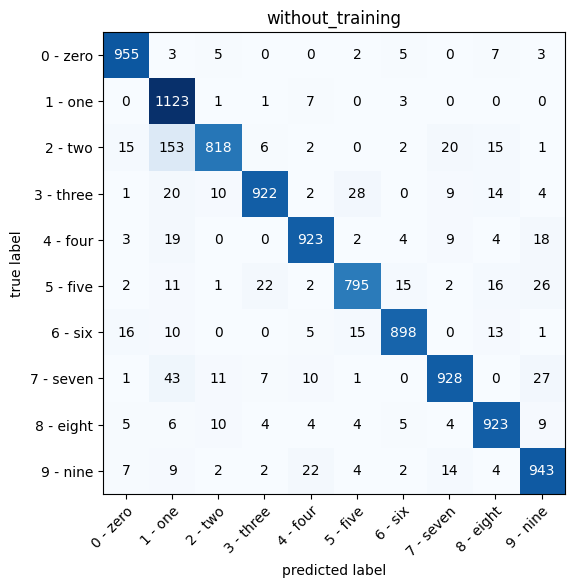

92.28


In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Number of classes
num_classes = len(test_loader.dataset.classes)

# Create confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)

# Generate matrix
confmat_tensor = confmat(
    preds=y_pred_tensor,
    target=test_loader.dataset.targets
)

# Plot
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=test_loader.dataset.classes,
    figsize=(10,6)
)
plt.title('without_training')
plt.show()
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc
accuracy = accuracy_fn(test_loader.dataset.targets, y_pred_tensor)
print(accuracy)

